# Assignment 2 -  Extended Kalman filter and Unscented Kalman filter


- **Topic:** Desiging an EKF and UKF to estimate the position using magnetic field information
- **Assessment:** The assignment will go through a pass/fail check.


- **Deadline:**  06-03-2026, 17:00
- **Submitting: SUBMIT ONLY `assignment2_groupNumber.ipynb` TO BRIGHTSPACE**, where groupNumber is your groupnumber



## Instructions
**Installation:** The implementation is tested with python 3.9.12 and packages including
-   numpy version: 1.26.4
-   scipy version: 1.13.0
-   matplotlib version: 3.5.1


Other (not too old or new) versions will probabily also work. For windows user check the announcement (**"Fix of Issues Assignment 1"**) on brightspace which could also be helpful for this assignment.

You may not use other packages for algorithm-related calculations.
You only need to complete (and submit) this file.
Please do not change the additional files `GP.py`, `helper.py` and `linAlg.py` and the dictionary `modelParameters` as this might result in breaking the assignment.



## AI Related Policy
We strongly discourage you to use AI tools for implementation assistance. It is your understanding of the problem that is tested in the final exam.


## Information
Please fill in your group number, names and student numbers in the cell below.

<!-- first EKF and then UKF, very similar to normal KF-->

In [1]:
''' YOUR ANSWER HERE '''
groupNumber = 10

STUDENT_1_NAME = "Jack Hines"
STUDENT_1_STUDENT_NUMBER = "6361803"

STUDENT_2_NAME = "Sebestyen Uray"
STUDENT_2_STUDENT_NUMBER = "6561632"

# raise NotImplementedError()

## Objectives

#### Goal

The goal of this assignment is to estimate the position $ \mathbf{x}_k $ of an agent, the same as assignment 1, but using different algorithmns. The agent moves in an indoor environment and gets information about its approximate change in position $ \Delta \mathbf{x}_k $ at every time-step. To model this, you may assume a linear dynamic model of the form:
$$\mathbf{x}_{k + 1} = \mathbf{x}_k + \Delta \mathbf{x}_{k} + \mathbf{w}_{k}$$

Where:

- $\mathbf{x}_k$ is a 3-dimensional position vector of the agent at time-step $k$. 

- $\Delta \mathbf{x}_k$ is the change in positon.

- $\mathbf{w}_k \sim \mathcal{N}(0_{3 \times 1}, \mathbf{Q})$ is Gaussian white noise.

- $ \mathbf{Q} \in \mathbb{R}^{3 \times 3} $ is the covariance of the process noise.

Since the information of the change in position $ \Delta \mathbf{x}_k$ contains errors, the position estimates from the dynamic model will drift. This means that over time, the agent will lose track of where it actually is. To remedy this, the agent is carrying a magnetometer, and has a map of the magnetic field. The magnetometer samples a measurement of the magnetic field $\mathbf{y}_k$ at every position $\mathbf{x}_k$. The map of the magnetic field is modeled by a non-linear function: a reduced rank Gaussian process (you do not need to understand, model or change the GP model, only to call the function evaluation). This results in the non-linear measurement model:
$$ \mathbf{y}_k = f(\mathbf{x}_k) + \mathbf{v}_k $$

Where:

- $\mathbf{y}_k$ is a 3-dimensional measurement vector of the magnetic field at time-step $k$.

- $f(\cdot)$ is the reduced rank Gaussian process function.

- $\mathbf{v}_k \sim \mathcal{N}(0_{3 \times 1}, \mathbf{R})$ is Gaussian white noise.

- $ \mathbf{R} \in \mathbb{R}^{3 \times 3} $ is the covariance of the measurement noise.


#### First load in the data
To start, first load in the data below
All variables you will use are numpy arrays, where
- `magnetometerMeasurements` $\in \mathbb{R}^{3 \times \text{K}}$ is a numpy array containing the magnetometer measurements
- `magnetometerInitialPosition` $\in \mathbb{R}^{3 \times 1}$ is a numpy array containing the initial position of the magnetometer
- `deltaMagnetometerPositions` $\in \mathbb{R}^{3 \times \text{K}}$ is a numpy array containing the change in position of the magnetometer

#### Warning
- Additionally you are provided with a dictionary modelParameters which is used in creating magnetic field maps. DO NOT CHANGE dictionary as this might break the assignment. To create the EKF and UKF you DO NOT need this dictionary.

In [4]:
''' DO NOT CHANGE THE CODE BELOW '''
import numpy as np
import matplotlib.pyplot as plt

import GP as GP

import linAlg as linAlg
import helper as helper
np.random.seed(groupNumber)

(magnetometerMeasurements, 
 magnetometerInitialPosition, 
 deltaMagnetometerPositions,
 modelParameters) = helper.initializeKalmanFilterAssignment(groupNumber % 29)


Same as the first assignment of particle filter, below, a function `helper.makeDeadReckoningPlots()` is given to plot the map of the magnetic field and the ground truth position of the path taken by the agent. The agent does not know this path, it only has access to its initial position, the change in position at every time-step and the magnetometer measurements. You can reuse the code for the plots.

Your first task it to use the agent's dynamic model to try and reconstruct the ground truth path. This is also known as dead reckoning and should be done using data stored in the variables `magnetometerInitialPosition` and `deltaMagnetometerPositions`. Save the agent's positions according to the dynamic model in the variable `deadReckoning` $\in \mathbb{R}^{3 \times \text{K}}$. Additionally, compare the magnetometer measurements with the map of the magnetic field. To achieve this, store the norm of the magnetic field at every time-step in the variable `magneticFieldNorm` $\in \mathbb{R}^{\text{K}}$.

This function should output two subfigures. Every subfigure includes the magnetic field map in the background. On the left the ground truth positions are plotted together with the dead reckoning positions. On the right, the magnetic field measurements are plotted with  the ground truth positions over the magnetic field map.

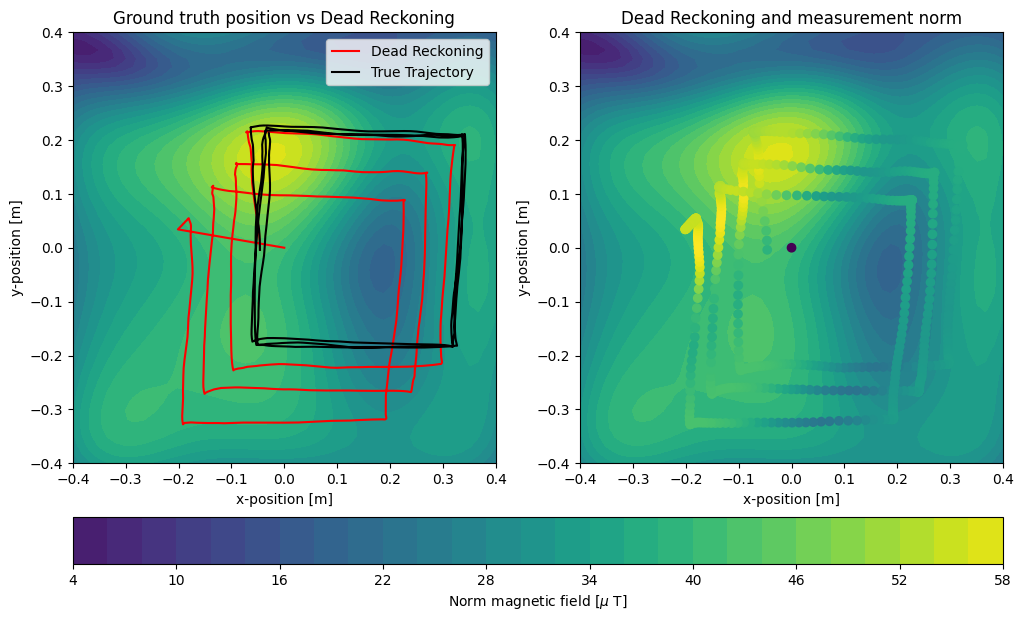

In [5]:
_,T= np.shape(deltaMagnetometerPositions)
deadReckoning = np.zeros((3,T))
magneticFieldNorm = np.zeros((T,1))
deadReckoning[:,[0]] = magnetometerInitialPosition + deltaMagnetometerPositions[:,[0]]
magneticFieldNorm[0] = np.linalg.norm(magnetometerMeasurements[:,0])

for i in range(1,T-1):
    deadReckoning[:,i] = deadReckoning[:,i-1] + deltaMagnetometerPositions[:,i] # update deadReckoning position without noise
    magneticFieldNorm[i] = np.linalg.norm(magnetometerMeasurements[:,i])

helper.makeDeadReckoningPlots(deadReckoning, magneticFieldNorm, modelParameters)

## EKF and UKF
To  use magnetometer measurements to reduce the positional drift observed in the figure above, besides PF in the previous lectures, you can also use EKF and UKF.

### EKF Implementation

You start from implementing EKF.  Your task is to fill in the following functions.

#### Task 1
Fill in the `dynamicUpdateEKF()` function according to the dynamic model given above. 

**Note:**
You do not have to change the inputs and outputs to the given functions.


In [6]:

def dynamicUpdateEKF(position, 
                   deltaPos, 
                   posCov, 
                   motionCovarianceEKF, 
                   modelParameters):
    ''' Dynamic update '''
    position = position + deltaPos # update position with deltaPos

    # find matrix F using first order taylor expansion of the motion model
    F = np.eye(3) # identity matrix for linear motion model
    posCov = F @ posCov @ F.T + motionCovarianceEKF 

    return position, posCov



#### Task 2

Complete the function `measurementUpdateEKF()` according to the measurement model given above. 

To implement the measurement model, you will need to make predictions of the magnetic field. You DO NOT need to create this function yourself. To make predictions, use the function `GP.makeMagneticFieldPrediction(positions, modelParameters)` function make sure the input `positions` $\in \mathbb{R}^{3 \times 1} $. The output should be a matrix $\in \mathbb{R}^{3 \times 1}$ magnetic field predictions for every input location.  Similarly, to find the Jacobian, you muse use the GP.makeMagneticFieldJacobian(position, modelParameters) function make sure the input position is a vector of 3x1. The output should be a matrix of 3x3.

In [7]:
def measurementUpdateEKF(position, 
                         magnetometerMeasurement, 
                         posCov, 
                         measurementCovarianceEKF,
                         modelParameters):
    
    ''' Measurement update '''

    magneticFieldPrediction = GP.makeMagneticFieldPrediction(position, modelParameters) # h(x_k|k-1) ?
    jacobianMagneticFieldPrediction = GP.makeMagneticFieldJacobian(position, modelParameters) # this is H?

    '''
    fill in your code
    '''
    #Kalman gain
    K = posCov @ jacobianMagneticFieldPrediction.T @ np.linalg.inv(jacobianMagneticFieldPrediction @ posCov @ jacobianMagneticFieldPrediction.T + measurementCovarianceEKF)
    innovation = magnetometerMeasurement - magneticFieldPrediction

    position = position + K @ innovation
    posCov = posCov - K @ jacobianMagneticFieldPrediction @ posCov # K eq. to term in covariance update equation

    return position, posCov

`extendedKalmanFilter()` is given as follows. You don't need to change it.

In [8]:
''' DO NOT CHANGE THE CODE BELOW '''

def extendedKalmanFilter(position, 
                         deltaPosition, 
                         magnetometerMeasurement, 
                         posCov, 
                         motionCovarianceEKF, 
                         measurementCovarianceEKF, 
                         modelParameters):
    ''' Estimates positions'''

    ''' Dynamic update '''    
    if modelParameters['NtimeStepEKF'] > 0:
        (position, 
         posCov) = dynamicUpdateEKF(position, 
                                  deltaPosition, 
                                  posCov, 
                                  motionCovarianceEKF,
                                  modelParameters)

    ''' Measurement update '''
    (position, 
     posCov) = measurementUpdateEKF(position,
                                    magnetometerMeasurement, 
                                    posCov, 
                                    measurementCovarianceEKF,
                                    modelParameters)

    return position, posCov


#### Task 3

Be sure to set the **initial position** and the **prior** on it correctly  and a **suitable measurement covariance** as you did in assignment 1.

You could start with the following parameters
- `motionCovarianceUKF` = np.eye(3)*0.001**2 
- `measurementCovarianceUKF` = np.eye(3)*1.5**2

Make sure `posCovarianceUKF` is a 3d tensor with the shape of `[3,3,NtimeSteps]`, to save the position covariances for every time step.
To get better results, you might have to tune these. 

In [9]:
''' Initialize the EKF '''
modelParameters['NtimeStepEKF'] = 0

motionCovarianceEKF = np.eye(3)*0.001**2
measurementCovarianceEKF =np.eye(3)*1.5**2

posEstEKF = np.zeros((3, modelParameters['NtimeSteps']))
posCovarianceEKF = np.zeros((3,3,modelParameters['NtimeSteps']))
''' Run the EKF'''

for timendx in range(modelParameters['NtimeSteps']-1):
    deltaPosEKF = deltaMagnetometerPositions[:, timendx:timendx+1]
    ymeasEKF = magnetometerMeasurements[:, timendx:timendx+1]
    (posEstEKF[:, timendx+1:timendx+2], 
     posCovarianceEKF[:, :, timendx+1]) = extendedKalmanFilter(posEstEKF[:, timendx:timendx+1], 
                                              deltaPosEKF, 
                                              ymeasEKF, 
                                              posCovarianceEKF[:, :, timendx],
                                              motionCovarianceEKF,
                                              measurementCovarianceEKF,
                                              modelParameters)
    modelParameters['NtimeStepEKF'] += 1

#### discussion

Elaborate on the effects of tuning the different variables:

- `motionCovarianceEKF`
- `measurementCovarianceEKF`
- The initial posiiton covariance `posCovarianceEKF[:, :, 0]`


#### Visualize the output
<!-- TODO: keep or not. maybe comparison between EKF and UKF in the end is enough -->

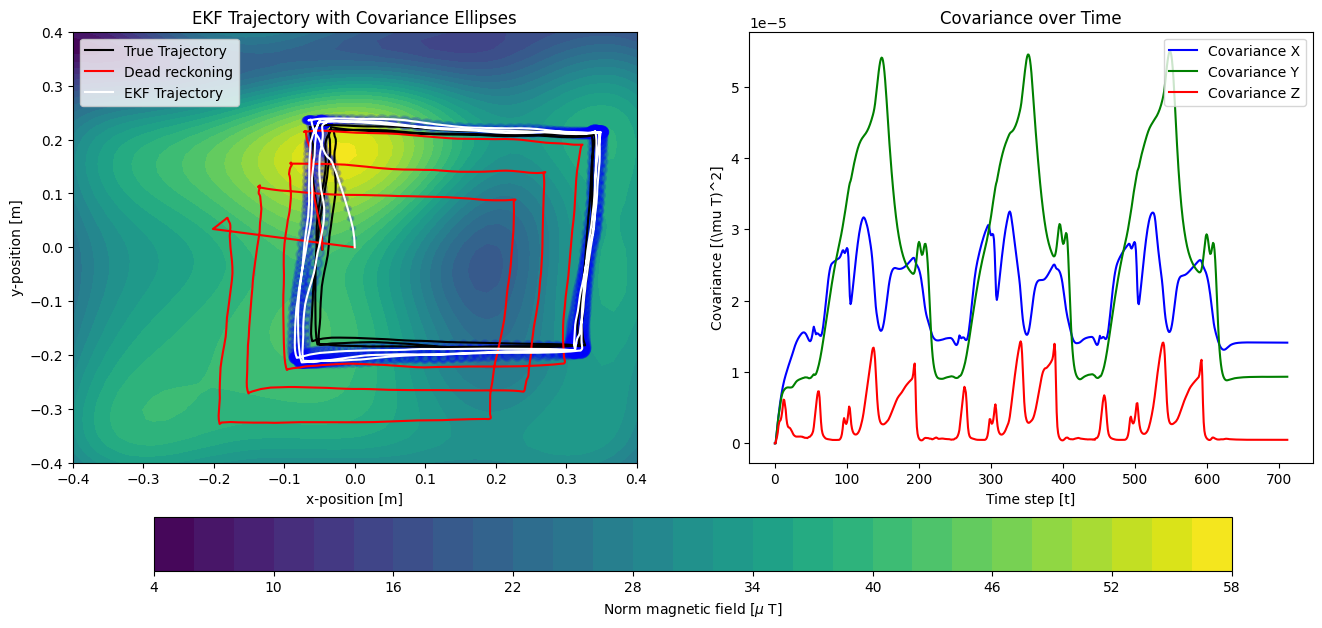

In [10]:
''' DO NOT CHANGE THE CODE BELOW '''
helper.makeExtendedKalmanFilterPlots(deadReckoning, posEstEKF, posCovarianceEKF, modelParameters)

**Discussion**

Explain why the covariance changes over time the way it does. You can create more plots if necessary for your analysis.

### UKF implement 

#### Task 1
Fill in the `dynamicUpdateUKF()` function according to the dynamic model given above. 

#### Note:
You do not have to change the inputs and outputs to the given functions.


In [ ]:
def dynamicUpdateUKF(position, 
                   deltaPos, 
                   posCov, 
                   motionCovarianceUKF, 
                   modelParameters):
    ''' Dynamic update '''
    position = " "    
    posCov = " "

    return position, posCov



#### Task 2

- Complete creating sigma points `createSigmaPoints()` and calculating sigma weights `calculateSigmaWeights()`.
- Fill in the `measurementUpdateUKF()` according to the measurement model given above. 
- You can play around with UT1 and UT2, can you see any obvious differences?


In [ ]:
def createSigmaPoints(stateVector, 
                      stateCovariance, 
                      lamdaWeights,
                      modelParameters):
    ''' Create sigma points '''

    # point 0 is the mean state vector
    sigmaPoints = np.zeros((3, 2*3+1)) # initialize 2n+1 sigma points
    sigmaPoints[:,0] = stateVector[:,0] # first sigma point is the mean state vector

    # square root of the state covariance matrix via Cholesky decomposition with jitter for numerical stability
    sqrtCov = linAlg.chol(stateCovariance)
    
    n = 3 
    for i in range(n):
        # index 1 to n+1 are for positive , n+2 to 2n+1 for negative
        sigmaPoints[:,i+1] = stateVector[:,0] + np.sqrt(n + lamdaWeights) * sqrtCov[i,:]
        sigmaPoints[:,i+n+1] = stateVector[:,0] - np.sqrt(n + lamdaWeights) * sqrtCov[i,:] 
     
    return sigmaPoints


def calculateSigmaWeights(UTnumber = 1):
    ''' Calculate the weights '''
    n = 3

    # use table from slide 31
    if UTnumber == 1:
        '''UT1'''
        lamdaWeights = 3-n
        alpha = np.sqrt(3-n)
        beta = 3/n - 1

    else:
        '''UT2'''
        lamdaWeights = 1e-6*n - n
        alpha = 1e-3
        beta = 2
    
    # initialize weights
    weightsMean = np.zeros(2*n+1)  
    weightsCov = np.zeros(2*n+1)
    # weight for central point
    weightsMean[0] = lamdaWeights/(n + lamdaWeights)
    weightsCov[0] = lamdaWeights/(n + lamdaWeights) + (1 - alpha**2 + beta)
    # weights fro all other points
    for i in range(1, 2*n+1):
        weightsMean[i] = 1/(2*(n + lamdaWeights))
        weightsCov[i] = 1/(2*(n + lamdaWeights))

    return lamdaWeights, weightsMean, weightsCov


def measurementUpdateUKF(position,
                         magnetometerMeasurement,
                         posCovariance,
                         measurementCovarianceUKF,
                         lamdaWeights, 
                         weightsMean, 
                         weightsCovariance,
                         modelParameters):
    
    ''' Measurement update '''
    # step 1: create sigma points
    sigmaPoints = createSigmaPoints(position, posCovariance, lamdaWeights, modelParameters)

    # step 2: propagate sigma points through measurement model
    sigmaOutput = np.zeros((3, 2*3+1))
    for i in range(2*3+1):
        sigmaOutput[:,i:i+1] = GP.makeMagneticFieldPrediction(sigmaPoints[:,i:i+1], modelParameters)

    # step 3: calculate mean and covariance of the propagated sigma points
    meanOutput = np.zeros((3,1))
    for i in range(2*3+1):
        meanOutput += weightsMean[i]*sigmaOutput[:,i:i+1]
    yPred = meanOutput # predicted measurement

    Ck = np.zeros((3,3))
    Sk = np.zeros((3,3))
    for i in range(2*3+1):
        diff = sigmaOutput[:,i:i+1] - yPred
        Ck += weightsCovariance[i]*diff@diff.T
        Sk = Ck + measurementCovarianceUKF # from slide 28

    # step 4: Kalman gain and update
    K = Ck @ np.linalg.inv(Sk) 
    
    position = position + K @ (magnetometerMeasurement - yPred)
    posCovariance = posCovariance - K @ Sk @ K.T

    return position, posCovariance


`unscentedKalmanFilter()` is given as follows. You don't need to change it.

In [22]:
''' DO NOT CHANGE THE CODE BELOW '''
def unscentedKalmanFilter(position, 
                          deltaPos, 
                          magnetometerMeasurement, 
                          posCovariance, 
                          motionCovarianceUKF,
                          measurementCovarianceUKF,
                          lamdaWeights, 
                          weightsMean, 
                          weightsCovariance,
                          modelParameters):

    if modelParameters['NtimeStepUKF'] > 0:
        ''' State update '''
        # try using the dynamic update function from the EKF for the state update, it may be the same tbh
        position, posCovariance = dynamicUpdateEKF(position, 
                                                deltaPos, 
                                                posCovariance, 
                                                motionCovarianceUKF, 
                                                modelParameters)

    ''' Measurement update '''
    position, posCovariance = measurementUpdateUKF(position, 
                                                   magnetometerMeasurement, 
                                                   posCovariance, 
                                                   measurementCovarianceUKF,
                                                   lamdaWeights,
                                                   weightsMean,
                                                   weightsCovariance,
                                                   modelParameters)

    return position, posCovariance



#### Task 3

Be sure to set the **initial position** and the **prior** on it correctly  and a **suitable measurement covariance** as you did in assignment 1.

You could start with the following parameters
- `motionCovarianceUKF` = np.eye(3)*0.001**2 
- `measurementCovarianceUKF` = np.eye(3)*1.5**2

Make sure `posCovarianceUKF` is a 3d tensor with the shape of `[3,3,NtimeSteps]`, to save the position covariances for every time step.
To get better results, you might have to tune these. 

In [24]:

''' Initialize the UKF '''
modelParameters['NtimeStepUKF'] = 0


motionCovarianceUKF = np.eye(3)*0.001**2    
measurementCovarianceUKF = np.eye(3)*1.5**2
posEstUKF = np.zeros((3, modelParameters['NtimeSteps']))
posEstUKF[:,0:1] = magnetometerInitialPosition
posCovarianceUKF = np.zeros((3, 3, modelParameters['NtimeSteps']))
posCovarianceUKF[:,:,0] = np.eye(3)*0.001**2

lamdaWeights, weightsMean, weightsCovariance = calculateSigmaWeights()
''' Run the UKF'''
for timendx in range(modelParameters['NtimeSteps']-1):
    (posEstUKF[:, timendx+1:timendx+2], 
     posCovarianceUKF[:, :, timendx+1]) = unscentedKalmanFilter(posEstUKF[:, timendx:timendx+1], 
                                               deltaMagnetometerPositions[:, timendx:timendx+1], 
                                               magnetometerMeasurements[:, timendx:timendx+1], 
                                               posCovarianceUKF[:, :, timendx],
                                               motionCovarianceUKF,
                                               measurementCovarianceUKF,
                                               lamdaWeights, 
                                               weightsMean, 
                                               weightsCovariance,
                                               modelParameters)
    modelParameters['NtimeStepUKF'] += 1



posCovarianceEKF = np.zeros((3, 3, modelParameters['NtimeSteps']))
posCovarianceEKF[:,:,0] = np.eye(3)*0


LinAlgError: Matrix is not positive definite

#### discussion

Elaborate on the effects of tuning the different variables:

- `motionCovarianceUKF`
- `measurementCovarianceUKF`
- The initial posiiton covariance `posCovarianceUKF[:, :, 0]`

Is it different from tuning the variables for the EKF?

### compare EKF and UKF
#### Visualize the output

In [ ]:
helper.makeKalmanFilterPlots(deadReckoning, posEstEKF, posEstUKF, modelParameters)

#### Discussion
Elaborate on the two plots.
- Compare the results from the UKF with the EKF? Does one provide better results? Elaborate!
- Comment on the reason for choosing either EKF, UKF of PF for this non-linear estimation problem. Also relate this to the results from assignment 1. 
- In what type of estimation problems would you expect to see very different results for the EKF, UKF and PF? 


<!-- TODO: DO WE NEED THE "PLAY AROUND WITH DIFFERENT PARAMETERS SESSION AS THE FIRST ASSIGMENT?" -->